# Loading the Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tensorflow==2.9.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 35.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 24.3.25
    Uninstalling flatbuffers-24.3.25:
      Successfully uninstalled flatbuffers-24.3.25
  Attempting uninstall: tensorboard-data-serve

In [2]:
from zipfile import ZipFile

# Path to the zip file
zip_path = '/content/drive/MyDrive/vehicle_face_rec/dataset.zip'

# Directory to extract the contents to
extract_dir = '/content/drive/MyDrive/vehicle_face_rec/dataset'

# Extract the zip file
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction completed!")


Extraction completed!


In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import sys
import os
from keras.applications.vgg16 import VGG16
import keras
from numpy import load
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras import backend
from keras.layers import Dense
from keras.layers import Flatten
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.optimizers import SGD
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.layers import Dropout
from keras.layers import BatchNormalization

# Image Preprocessing

In [7]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
traindir = "/content/drive/MyDrive/vehicle_face_rec/dataset"
validdir = "/content/drive/MyDrive/vehicle_face_rec/dataset"
testdir = "/content/drive/MyDrive/vehicle_face_rec/dataset"

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32
training_set = train_datagen.flow_from_directory(traindir,
                                                 target_size=(75, 75),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')

valid_set = valid_datagen.flow_from_directory(validdir,
                                            target_size=(75, 75),
                                            batch_size=batch_size,
                                            class_mode='categorical')


Found 400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [8]:
class_dict = training_set.class_indices
print(class_dict)

{'guhan': 0, 'regu': 1}


In [9]:
li = list(class_dict.keys())
print(li)

['guhan', 'regu']


In [10]:
train_num = training_set.samples
valid_num = valid_set.samples

# Model Preparation

In [11]:
from keras.applications import VGG16

# Path to the downloaded weights file
weights_path = '/content/drive/MyDrive/vehicle_face_rec/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Load the VGG16 model with pre-trained weights
base_model = VGG16(weights=weights_path, include_top=False, input_shape=(75, 75, 3))

# Set the model to be non-trainable
base_model.trainable = False

# base_model=VGG16(include_top=False,input_shape=(75,75,3))
# base_model.trainable=False


In [ ]:
# base_model=VGG16(include_top=False,input_shape=(224,224,3))
# base_model.trainable=False

In [15]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

classifier = Sequential()
classifier.add(base_model)
classifier.add(Flatten())
classifier.add(Dense(2, activation='softmax'))  # Change the number of units to match the number of classes (15)
classifier.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 14,718,786
Trainable params: 4,098
Non-trainable params: 14,714,688
_________________________________________________________________


In [16]:
classifier.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
#fitting images to CNN
history = classifier.fit(training_set,
                         steps_per_epoch=train_num//batch_size,
                         validation_data=valid_set,
                         epochs=10,
                         validation_steps=valid_num//batch_size,
                         )
#saving model
#filepath="Mymodel.hdf5"
#model.save(filepath)

Epoch 1/10
12/12 [==============================] - 85s 7s/step - loss: 0.5284 - accuracy: 0.7826 - val_loss: 0.2482 - val_accuracy: 0.9766
Epoch 2/10
12/12 [==============================] - 99s 8s/step - loss: 0.2181 - accuracy: 0.9728 - val_loss: 0.1011 - val_accuracy: 0.9922
Epoch 3/10
12/12 [==============================] - 90s 8s/step - loss: 0.1247 - accuracy: 0.9701 - val_loss: 0.0775 - val_accuracy: 1.0000
Epoch 4/10
12/12 [==============================] - 96s 8s/step - loss: 0.0733 - accuracy: 0.9973 - val_loss: 0.0443 - val_accuracy: 0.9974
Epoch 5/10
12/12 [==============================] - 94s 8s/step - loss: 0.0597 - accuracy: 0.9891 - val_loss: 0.0390 - val_accuracy: 1.0000
Epoch 6/10
12/12 [==============================] - 90s 8s/step - loss: 0.0651 - accuracy: 0.9891 - val_loss: 0.0340 - val_accuracy: 1.0000
Epoch 7/10
12/12 [==============================] - 69s 6s/step - loss: 0.0440 - accuracy: 1.0000 - val_loss: 0.0244 - val_accuracy: 1.0000
Epoch 8/10
12/12 [==

In [18]:
%cd '/content/drive/MyDrive/vehicle_face_rec'

/content/drive/MyDrive/vehicle_face_rec


In [19]:
#Saving our model
filepath="Mymodel.h5"
classifier.save(filepath)

Visualizing the Accuracy

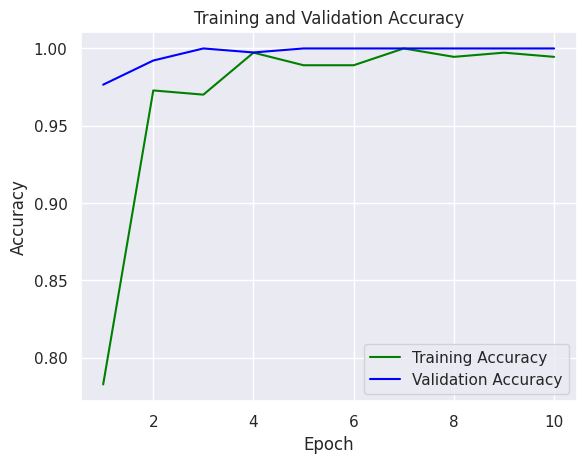

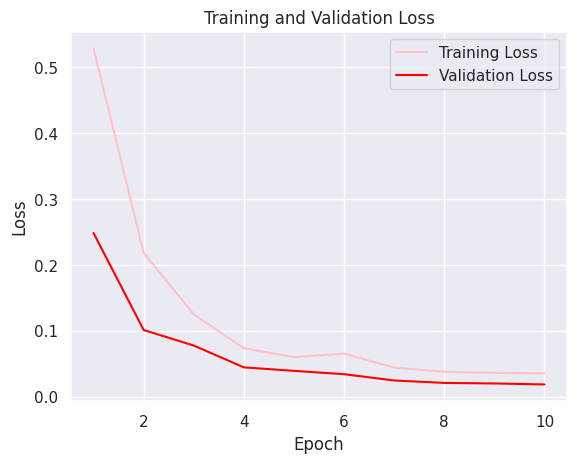

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [23]:
# predicting an image
from keras.preprocessing import image
import numpy as np
image_path = "/content/drive/MyDrive/vehicle_face_rec/dataset/regu/regu100.jpg"
new_img = image.load_img(image_path, target_size=(75, 75))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

print("Following is our prediction:")
prediction = classifier.predict(img)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
d = prediction.flatten()
j = d.max()
for index,item in enumerate(d):
    if item == j:
        class_name = li[index]

#ploting image with predicted class name
plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.title(class_name)
plt.show()

AttributeError: module 'keras.preprocessing.image' has no attribute 'load_img'

Following is our prediction:
1/1 [==============================] - 0s 314ms/step


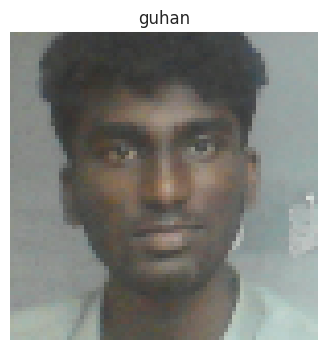

In [26]:
# predicting an image
from tensorflow.keras.utils import load_img # import load_img from tensorflow.keras.utils
from tensorflow.keras.utils import img_to_array # import img_to_array from tensorflow.keras.utils
import numpy as np
image_path = "/content/drive/MyDrive/vehicle_face_rec/dataset/guhan/guhan12.jpg"
new_img = load_img(image_path, target_size=(75, 75)) # use load_img imported from tensorflow.keras.utils
img = img_to_array(new_img) # use img_to_array imported from tensorflow.keras.utils
img = np.expand_dims(img, axis=0)
img = img/255

print("Following is our prediction:")
prediction = classifier.predict(img)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
d = prediction.flatten()
j = d.max()
for index,item in enumerate(d):
    if item == j:
        class_name = li[index]

#ploting image with predicted class name
plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.title(class_name)
plt.show()

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load the test dataset
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    testdir,
    target_size=(75, 75),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model on the test dataset
scores = classifier.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Test Loss:", scores[0])
print("Test Accuracy:", scores[1])

# Generate predictions for the test data
test_predictions = classifier.predict(test_generator)
predicted_labels = np.argmax(test_predictions, axis=1)

# True labels for the test data
true_labels = test_generator.classes

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
# print("Confusion Matrix:")
# print(conf_matrix)


Found 400 images belonging to 2 classes.


<ipython-input-27-260ca46bf4e0>:14: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = classifier.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)


13/13 [==============================] - 50s 4s/step - loss: 0.0186 - accuracy: 1.0000
Test Loss: 0.01856136880815029
Test Accuracy: 1.0
13/13 [==============================] - 29s 2s/step
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


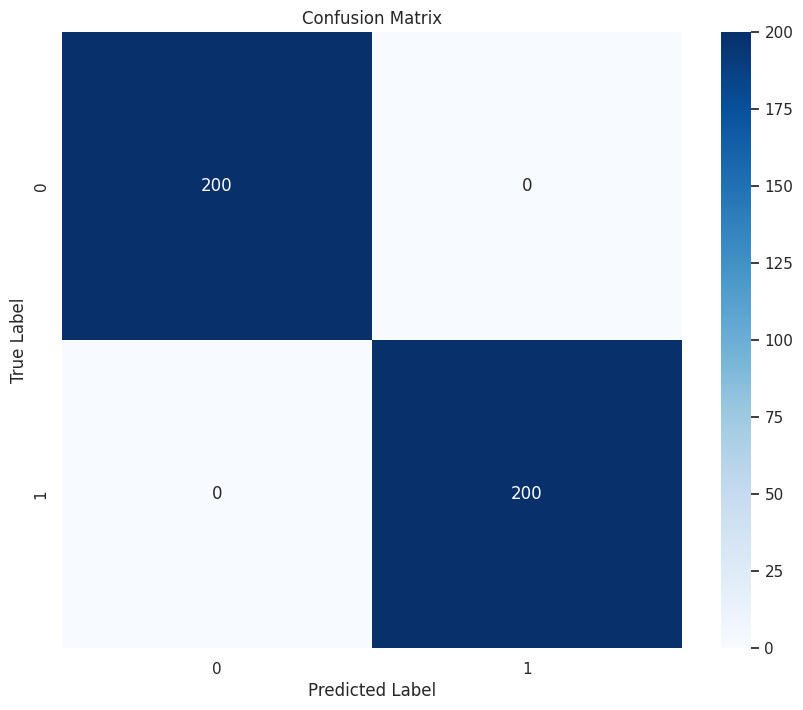

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


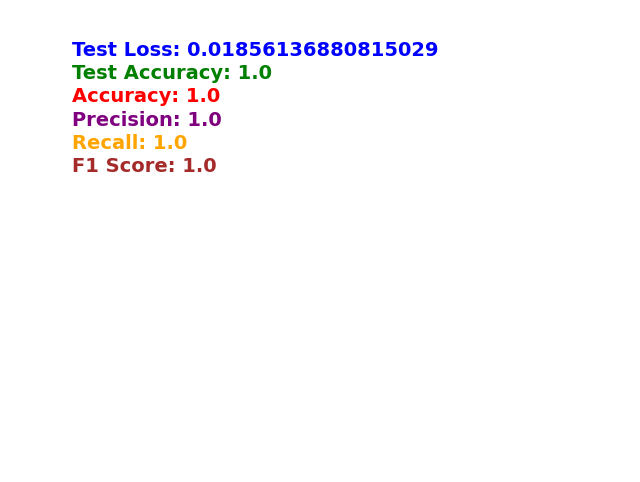

In [29]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Display the parameters as text with bold colors and bigger font
ax.text(0.1, 0.9, f"Test Loss: {scores[0]}", fontsize=14, color='blue', weight='bold')
ax.text(0.1, 0.85, f"Test Accuracy: {scores[1]}", fontsize=14, color='green', weight='bold')
ax.text(0.1, 0.8, f"Accuracy: {accuracy}", fontsize=14, color='red', weight='bold')
ax.text(0.1, 0.75, f"Precision: {precision}", fontsize=14, color='purple', weight='bold')
ax.text(0.1, 0.7, f"Recall: {recall}", fontsize=14, color='orange', weight='bold')
ax.text(0.1, 0.65, f"F1 Score: {f1}", fontsize=14, color='brown', weight='bold')

# Remove axis
ax.axis('off')

# Show the plot
plt.show()


/opt/conda/lib/python3.7/site-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Found 4128 images belonging to 15 classes.


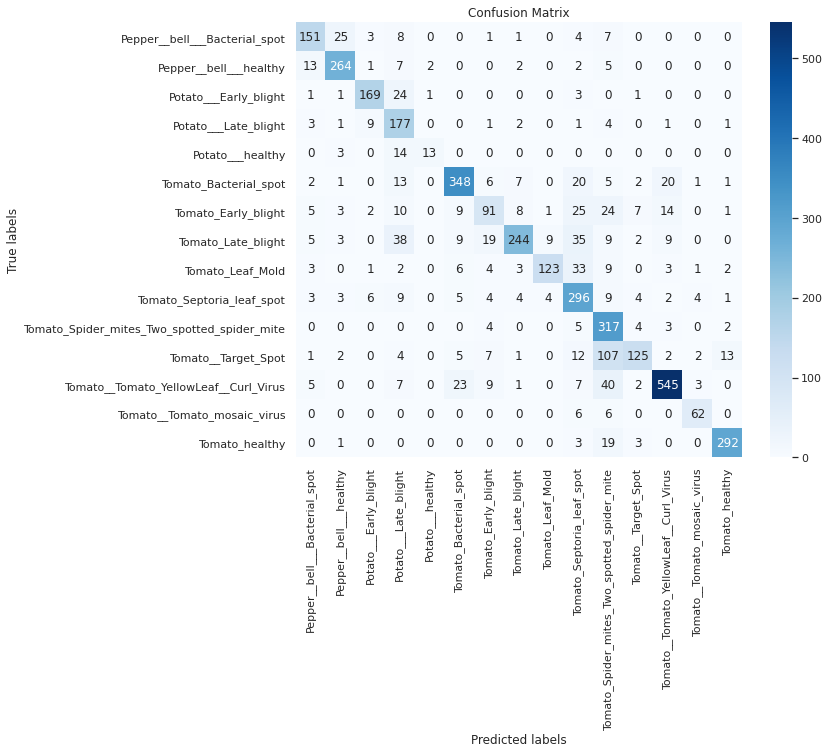

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.79      0.76      0.77       200
                     Pepper__bell___healthy       0.86      0.89      0.88       296
                      Potato___Early_blight       0.88      0.84      0.86       200
                       Potato___Late_blight       0.57      0.89      0.69       200
                           Potato___healthy       0.81      0.43      0.57        30
                      Tomato_Bacterial_spot       0.86      0.82      0.84       426
                        Tomato_Early_blight       0.62      0.46      0.53       200
                         Tomato_Late_blight       0.89      0.64      0.75       382
                           Tomato_Leaf_Mold       0.90      0.65      0.75       190
                  Tomato_Septoria_leaf_spot       0.65      0.84      0.73       354
Tomato_Spider_mites_Two_spotted_spider_mite       0.57      0.95

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

# Load the saved model
model = load_model("Mymodel.h5")

# Define the test dataset directory
test_dir = "/kaggle/input/plant-village-dataset/PlantVillageDataset/train_val_test/test"

# Set up ImageDataGenerator for the test set
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow images from the test directory in batches
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(75, 75),
    batch_size=32,  # Adjust batch size as needed
    class_mode='categorical',
    shuffle=False  # Important to keep the order of predictions consistent for evaluation
)

# Get true labels
y_true = test_generator.classes

# Generate predictions
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


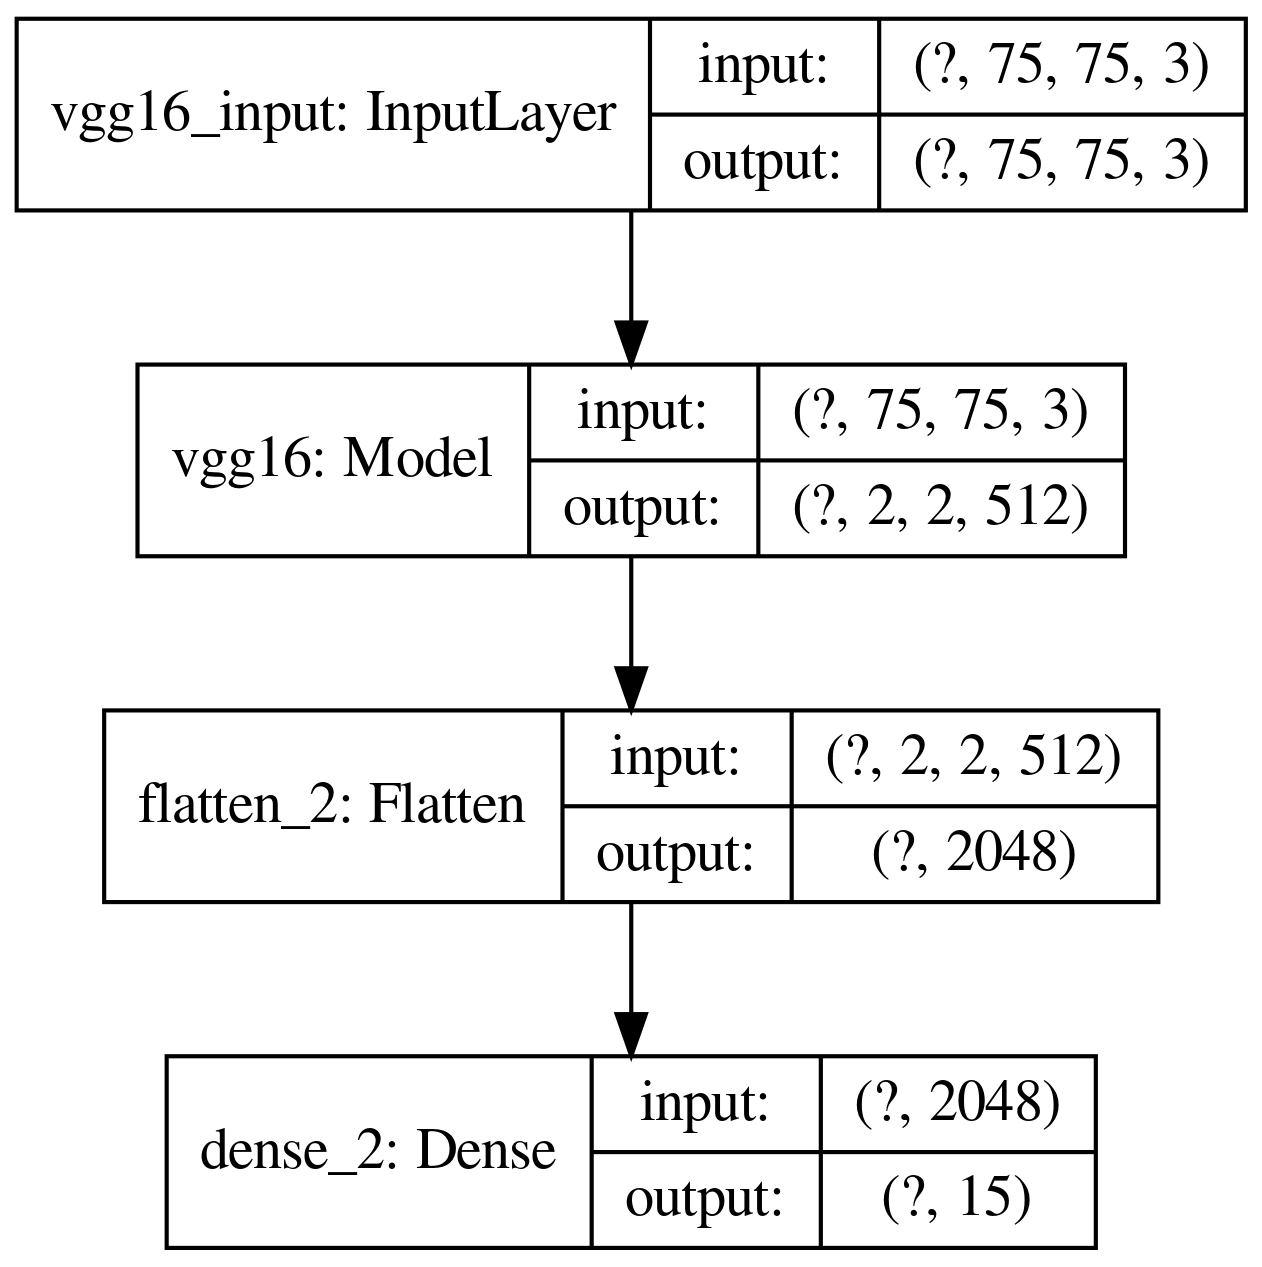

In [ ]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture with more emphasis and higher quality
plot_model(
    model,
    to_file='VGG-16.png',  # File to save the image
    show_shapes=True,             # Show shapes of the layers
    show_layer_names=True,        # Show names of the layers
    rankdir='TB',                 # Direction of the graph ('TB' for top to bottom, 'LR' for left to right)
    expand_nested=True,           # Expand nested models into clusters
    dpi=300                       # Set the resolution (dots per inch) for high quality
)
# print(model)


In [ ]:
import pytesseract
from PIL import Image

# Load the image
image_path = "/kaggle/working/VGG-16.png"
img = Image.open(image_path)

# Use pytesseract to extract text
text = pytesseract.image_to_string(img)

# Print the extracted text
print(text)


input: | (?, 75, 75, 3
vgg16_input: InputLayer ( )
(2, 75, 75, 3)

vgeg16: Model

flatten_2: Flatten (?, 2, 2, 512)
(2, 2048)

input: | (?, 2048

   
  

 
  

(2, 75, 75, 3)
(2, 2, 2, 512)
